In [3]:
import sys
sys.path.insert(0, '..//src')
sys.path.insert(0, '..//src//data')
sys.path.insert(0, '..//src//features')

import global_func as gf
import load_data
import data_preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

config_dir = '..\\config\\'
data_raw_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_RAW')
data_proc_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_PROCESSED')
data_remod_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_REMODEL')

# Data Collection

In [5]:
df_raw = gf.load_from_pkl(f'{data_proc_dir}df_raw.pkl')
df_raw.head()

,lq45,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s
date,,,,,,,,,
2012-04-24,709.97,4170.35,358.94,30.88,137.31,3.2003,2.8412,1.2536,1.6128
2012-04-25,708.00,4163.64,357.35,30.88,139.19,3.0555,2.6918,1.9225,2.2862
2012-04-26,712.20,4180.31,359.55,31.13,140.16,3.3293,3.8457,2.8350,2.3186
2012-04-27,708.39,4163.98,357.52,31.14,140.39,3.5716,4.6417,3.7988,2.7288
2012-04-30,711.38,4180.73,359.05,30.93,139.87,2.8769,3.2943,2.5111,2.0937


# Data Definition & Validation

In [6]:
print(df_raw.info())
print()
print(df_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2012-04-24 to 2022-03-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lq45    2416 non-null   float64
 1   jci     2416 non-null   float64
 2   idx30   2416 non-null   float64
 3   eido    2416 non-null   float64
 4   spy     2416 non-null   float64
 5   dom_b   2416 non-null   float64
 6   dom_s   2416 non-null   float64
 7   for_b   2416 non-null   float64
 8   for_s   2416 non-null   float64
dtypes: float64(9)
memory usage: 188.8 KB
None

lq45     0
jci      0
idx30    0
eido     0
spy      0
dom_b    0
dom_s    0
for_b    0
for_s    0
dtype: int64


## Resample data time-series: Interval = hari-kerja

In [7]:
DataPrep = data_preprocessing.DataPreprocessing()
df_proc = DataPrep.resampling(dataframe=df_raw, interval='B', resampling_method='median', fillna_method='ffill')
df_proc.tail()

,lq45,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s
date,,,,,,,,,
2022-03-25,1017.6660,7002.5322,544.181,24.79,452.69,8.6521,9.8707,4.9920,3.7734
2022-03-28,1026.8430,7049.6030,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587
2022-03-29,1019.0830,7011.6890,544.750,24.87,461.55,7.8961,8.9971,4.2180,3.1170
2022-03-30,1024.2159,7053.1899,547.368,24.81,458.70,9.0337,9.6315,4.7040,4.1061
2022-03-31,1022.9940,7071.4419,546.128,24.75,451.64,9.7775,10.5467,5.1009,4.3317


## Feature enriching

In [8]:
df_proc = DataPrep.enriching(dataframe=df_proc)
df_proc.tail()

,lq45,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s,dom_total,dom_net,for_total,for_net
date,,,,,,,,,,,,,
2022-03-25,1017.6660,7002.5322,544.181,24.79,452.69,8.6521,9.8707,4.9920,3.7734,18.5228,-1.2186,8.7654,1.2186
2022-03-28,1026.8430,7049.6030,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587,20.8568,-0.8578,7.5753,0.8579
2022-03-29,1019.0830,7011.6890,544.750,24.87,461.55,7.8961,8.9971,4.2180,3.1170,16.8932,-1.1010,7.3350,1.1010
2022-03-30,1024.2159,7053.1899,547.368,24.81,458.70,9.0337,9.6315,4.7040,4.1061,18.6652,-0.5978,8.8101,0.5979
2022-03-31,1022.9940,7071.4419,546.128,24.75,451.64,9.7775,10.5467,5.1009,4.3317,20.3242,-0.7692,9.4326,0.7692


# Data Splitting

In [ ]:
#df_train, df_valid, df_test = DataPrep.splitting(dataframe=df_proc, train_end='2020-12-31', valid_end='2021-07-31')
#gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train_01.pkl')
#gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid_01.pkl')
#gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test_01.pkl')

# EDA

In [9]:
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_01.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_01.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_01.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

## Explorasi Target

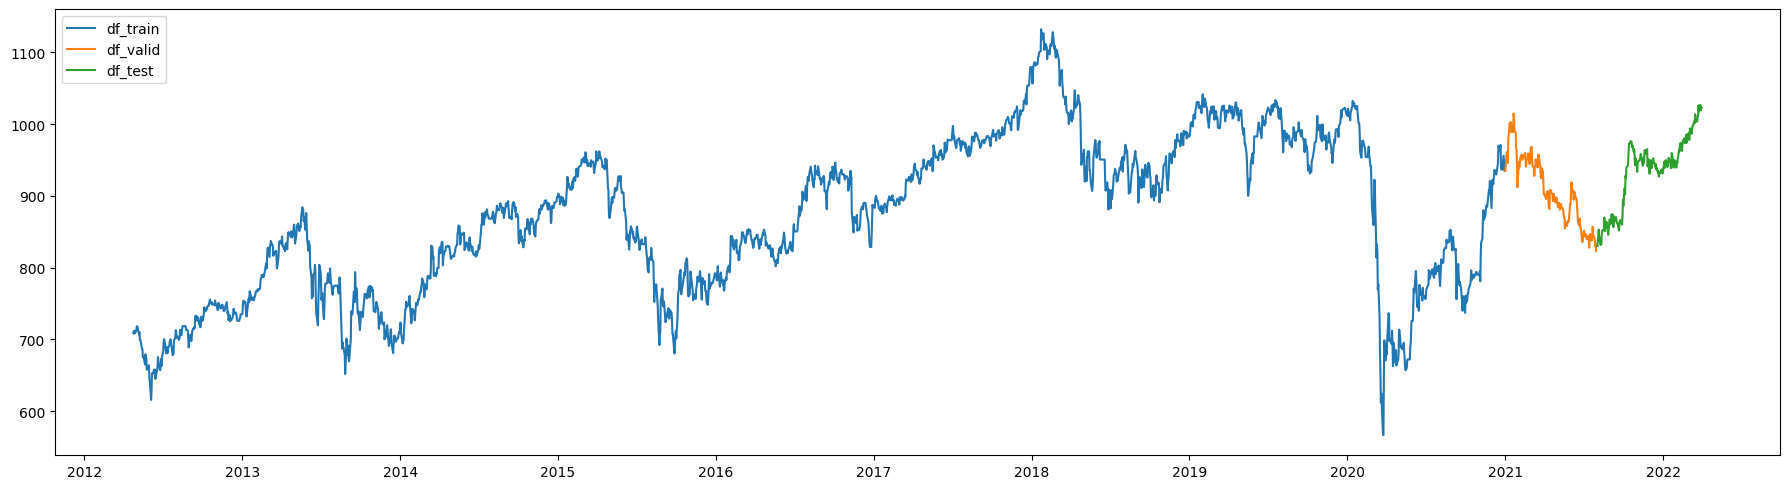

In [10]:
def plotting_target():
    fig = plt.figure(figsize=(18,5))
    for frame in [df_train, df_valid, df_test]:
        plt.plot(frame.index, frame['lq45'], label=frame.name)

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_target()

## Explorasi Tren

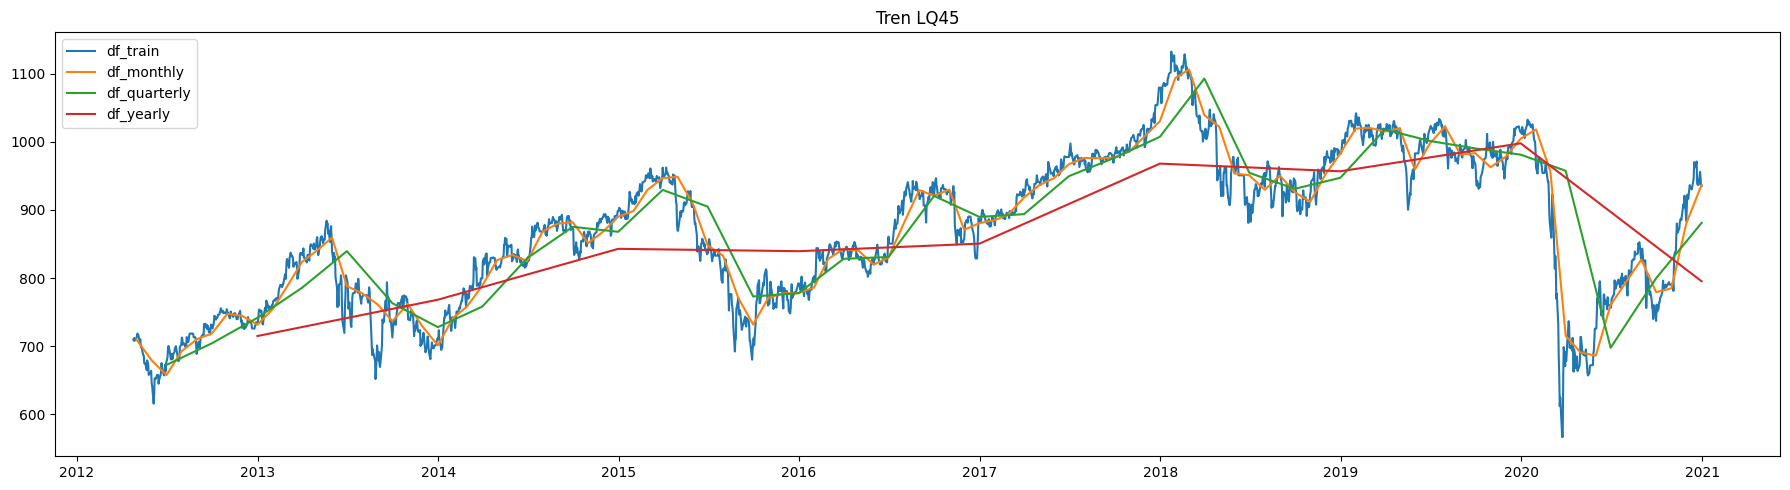

In [11]:
def plotting_tren(df):
    df_monthly = DataPrep.resampling(dataframe=df, interval='M', resampling_method='median', fillna_method='ffill')
    df_quarterly = DataPrep.resampling(dataframe=df, interval='Q', resampling_method='median', fillna_method='ffill')
    df_yearly = DataPrep.resampling(dataframe=df, interval='A', resampling_method='median', fillna_method='ffill')

    df_monthly.name = 'df_monthly'
    df_quarterly.name = 'df_quarterly'
    df_yearly.name = 'df_yearly'

    fig = plt.figure(figsize=(18,5))
    for frame in [df, df_monthly, df_quarterly, df_yearly]:
        plt.plot(frame.index, frame['lq45'], label=frame.name)

    plt.title('Tren LQ45')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_tren(df=df_train)

# Dekomposisi Seasonal

In [12]:
DataPrep = data_preprocessing.DataPreprocessing()
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_01.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_01.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_01.pkl')

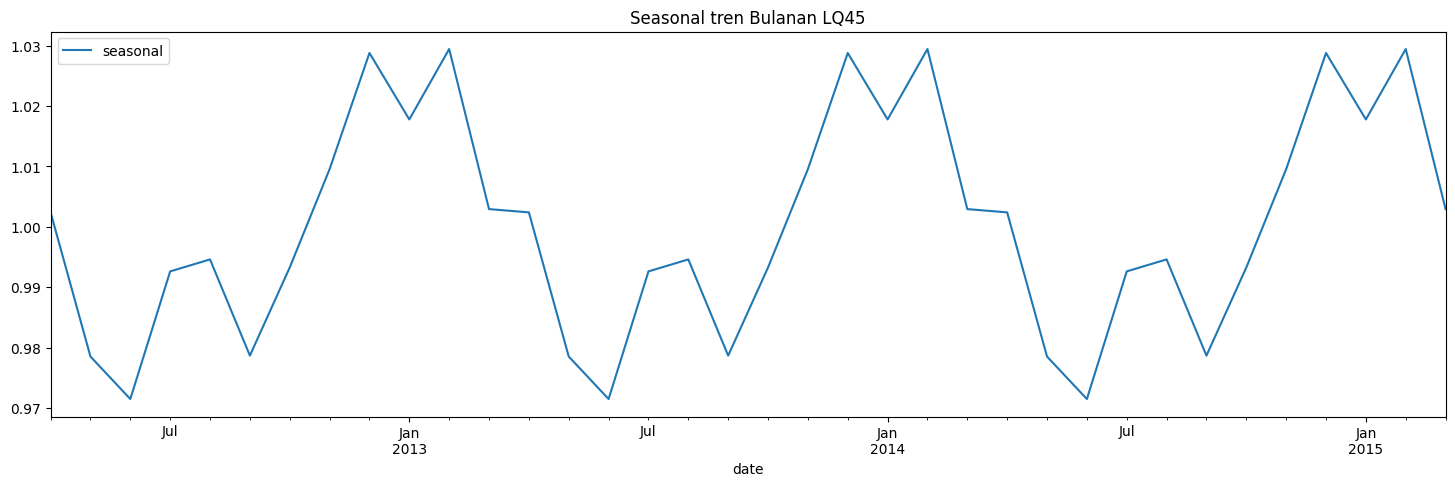

In [13]:
result_mul, _ = DataPrep.monthly_seasonal_feature(dataframe_train=df_train)

result_mul.seasonal[:36].to_frame().plot(subplots=True,figsize =(18,5))
plt.title('Seasonal tren Bulanan LQ45')
plt.show()

## Feature enriching: col seasonal

In [ ]:
#_, df_seasonal = DataPrep.monthly_seasonal_feature(dataframe_train=df_train)
#df_train,_ = DataPrep.enriching_seasonal(dataframe=df_train, df_seasonal=df_seasonal)
#df_valid,_ = DataPrep.enriching_seasonal(dataframe=df_valid, df_seasonal=df_seasonal)
#df_test,_ = DataPrep.enriching_seasonal(dataframe=df_test, df_seasonal=df_seasonal)
#gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train_02.pkl')
#gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid_02.pkl')
#gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test_02.pkl')

# Cek stasionary & Transform Lag-Differencing

In [18]:
DataPrep = data_preprocessing.DataPreprocessing()
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_02.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_02.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_02.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

## Augmented Dickey-Fuller Test
The time series is considered stationary if the p-value is low (<0.05) and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.

In [19]:
non_stationary_cols = DataPrep.stationary_checker_with_adfuller(dataframe=df_train, show_detail=True)
non_stationary_cols


COLUMN                        : lq45
  1. ADF                      : -2.4405397857898103
  2. P-Value                  : 0.13061964590889757
  3. Num Of Lags              : 14
  4. Num Of Observations Used : 2253
  5. Critical Values 1%       : -3.433255799449242
  6. Critical Values 5%       : -2.862823704909085
  7. Critical Values 10%      : -2.56745337629031
RESULT                        : NON-STATIONARY


COLUMN                        : jci
  1. ADF                      : -1.916966344974725
  2. P-Value                  : 0.32412218134446713
  3. Num Of Lags              : 14
  4. Num Of Observations Used : 2253
  5. Critical Values 1%       : -3.433255799449242
  6. Critical Values 5%       : -2.862823704909085
  7. Critical Values 10%      : -2.56745337629031
RESULT                        : NON-STATIONARY


COLUMN                        : idx30
  1. ADF                      : -2.182354790848638
  2. P-Value                  : 0.21271186391687474
  3. Num Of Lags              : 

['lq45', 'jci', 'idx30', 'eido', 'spy', 'dom_b', 'dom_s', 'dom_total']

In [15]:
#DataPrep = data_preprocessing.DataPreprocessing()
#pkl = r'..\models\pkl\list_non_stationary_cols.pkl'
#df_train = DataPrep.stationary_transform(dataframe=df_train, non_stationary_cols_pkl=pkl)
#df_valid = DataPrep.stationary_transform(dataframe=df_valid, non_stationary_cols_pkl=pkl)
#df_test = DataPrep.stationary_transform(dataframe=df_test, non_stationary_cols_pkl=pkl)
#gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train_03.pkl')
#gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid_03.pkl')
#gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test_03.pkl')


df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_03.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_03.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_03.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

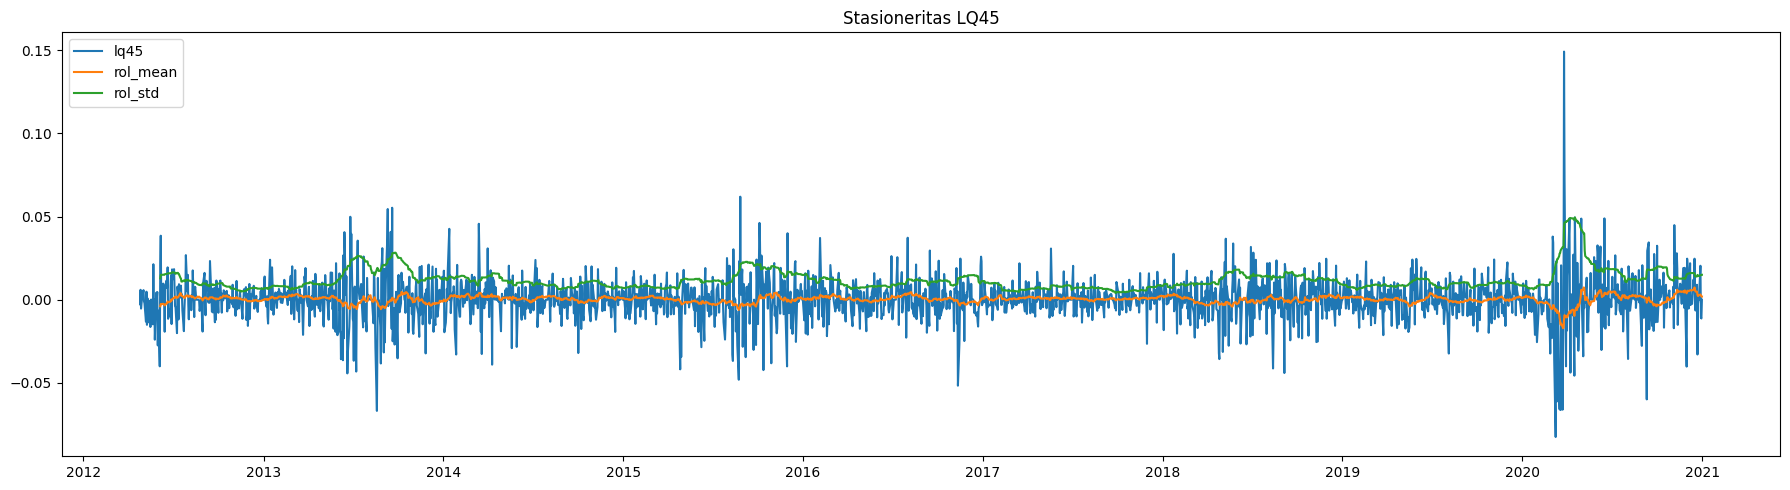

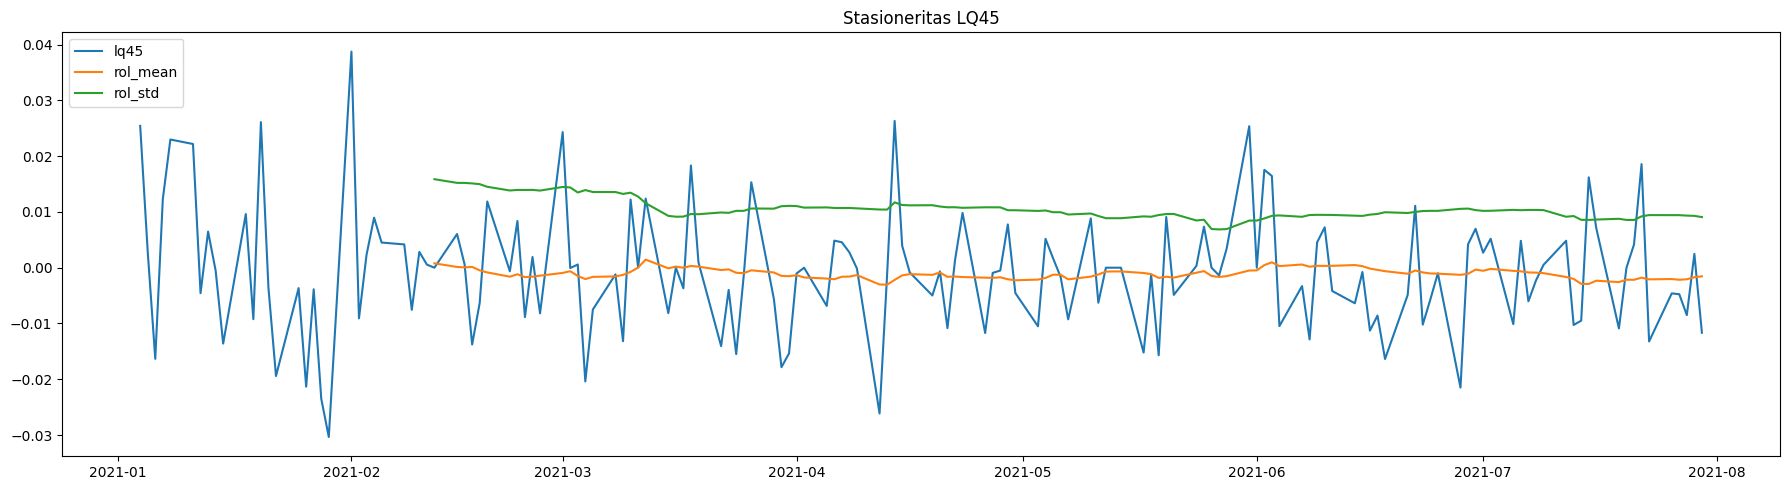

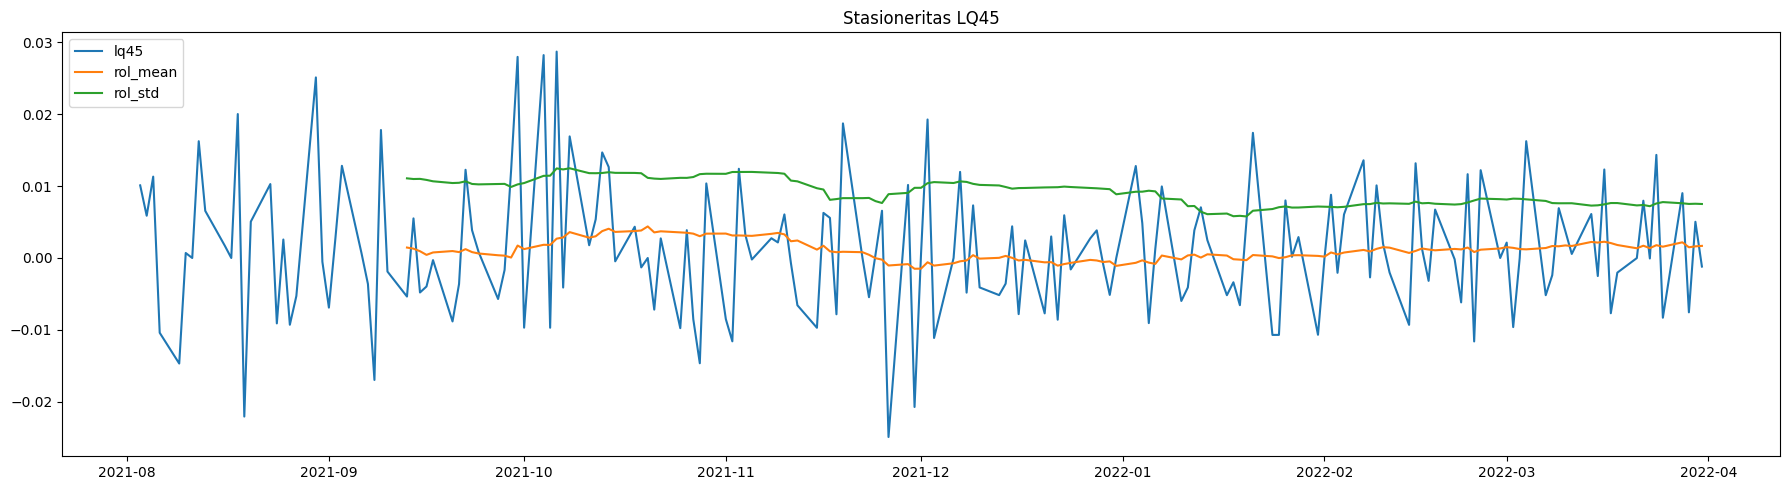

In [16]:
def plotting_stasioner(df, col):
    fig, axes = plt.subplots(figsize=[18, 5])

    rol_mean = df[col].rolling(window = 30, center = False).mean()
    rol_std = df[col].rolling(window = 30, center = False).std()

    axes.plot(df.index, df[col], label=col)
    axes.plot(rol_mean, label='rol_mean')
    axes.plot(rol_std, label='rol_std')

    axes.set_title(f'Stasioneritas {str(col).upper()}')
    axes.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_stasioner(df=df_train,col='lq45')
plotting_stasioner(df=df_valid,col='lq45')
plotting_stasioner(df=df_test,col='lq45')

# Cek Outlier & Imputasi

In [20]:
DataPrep = data_preprocessing.DataPreprocessing()
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_03.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_03.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_03.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

## Plotting: Histogram

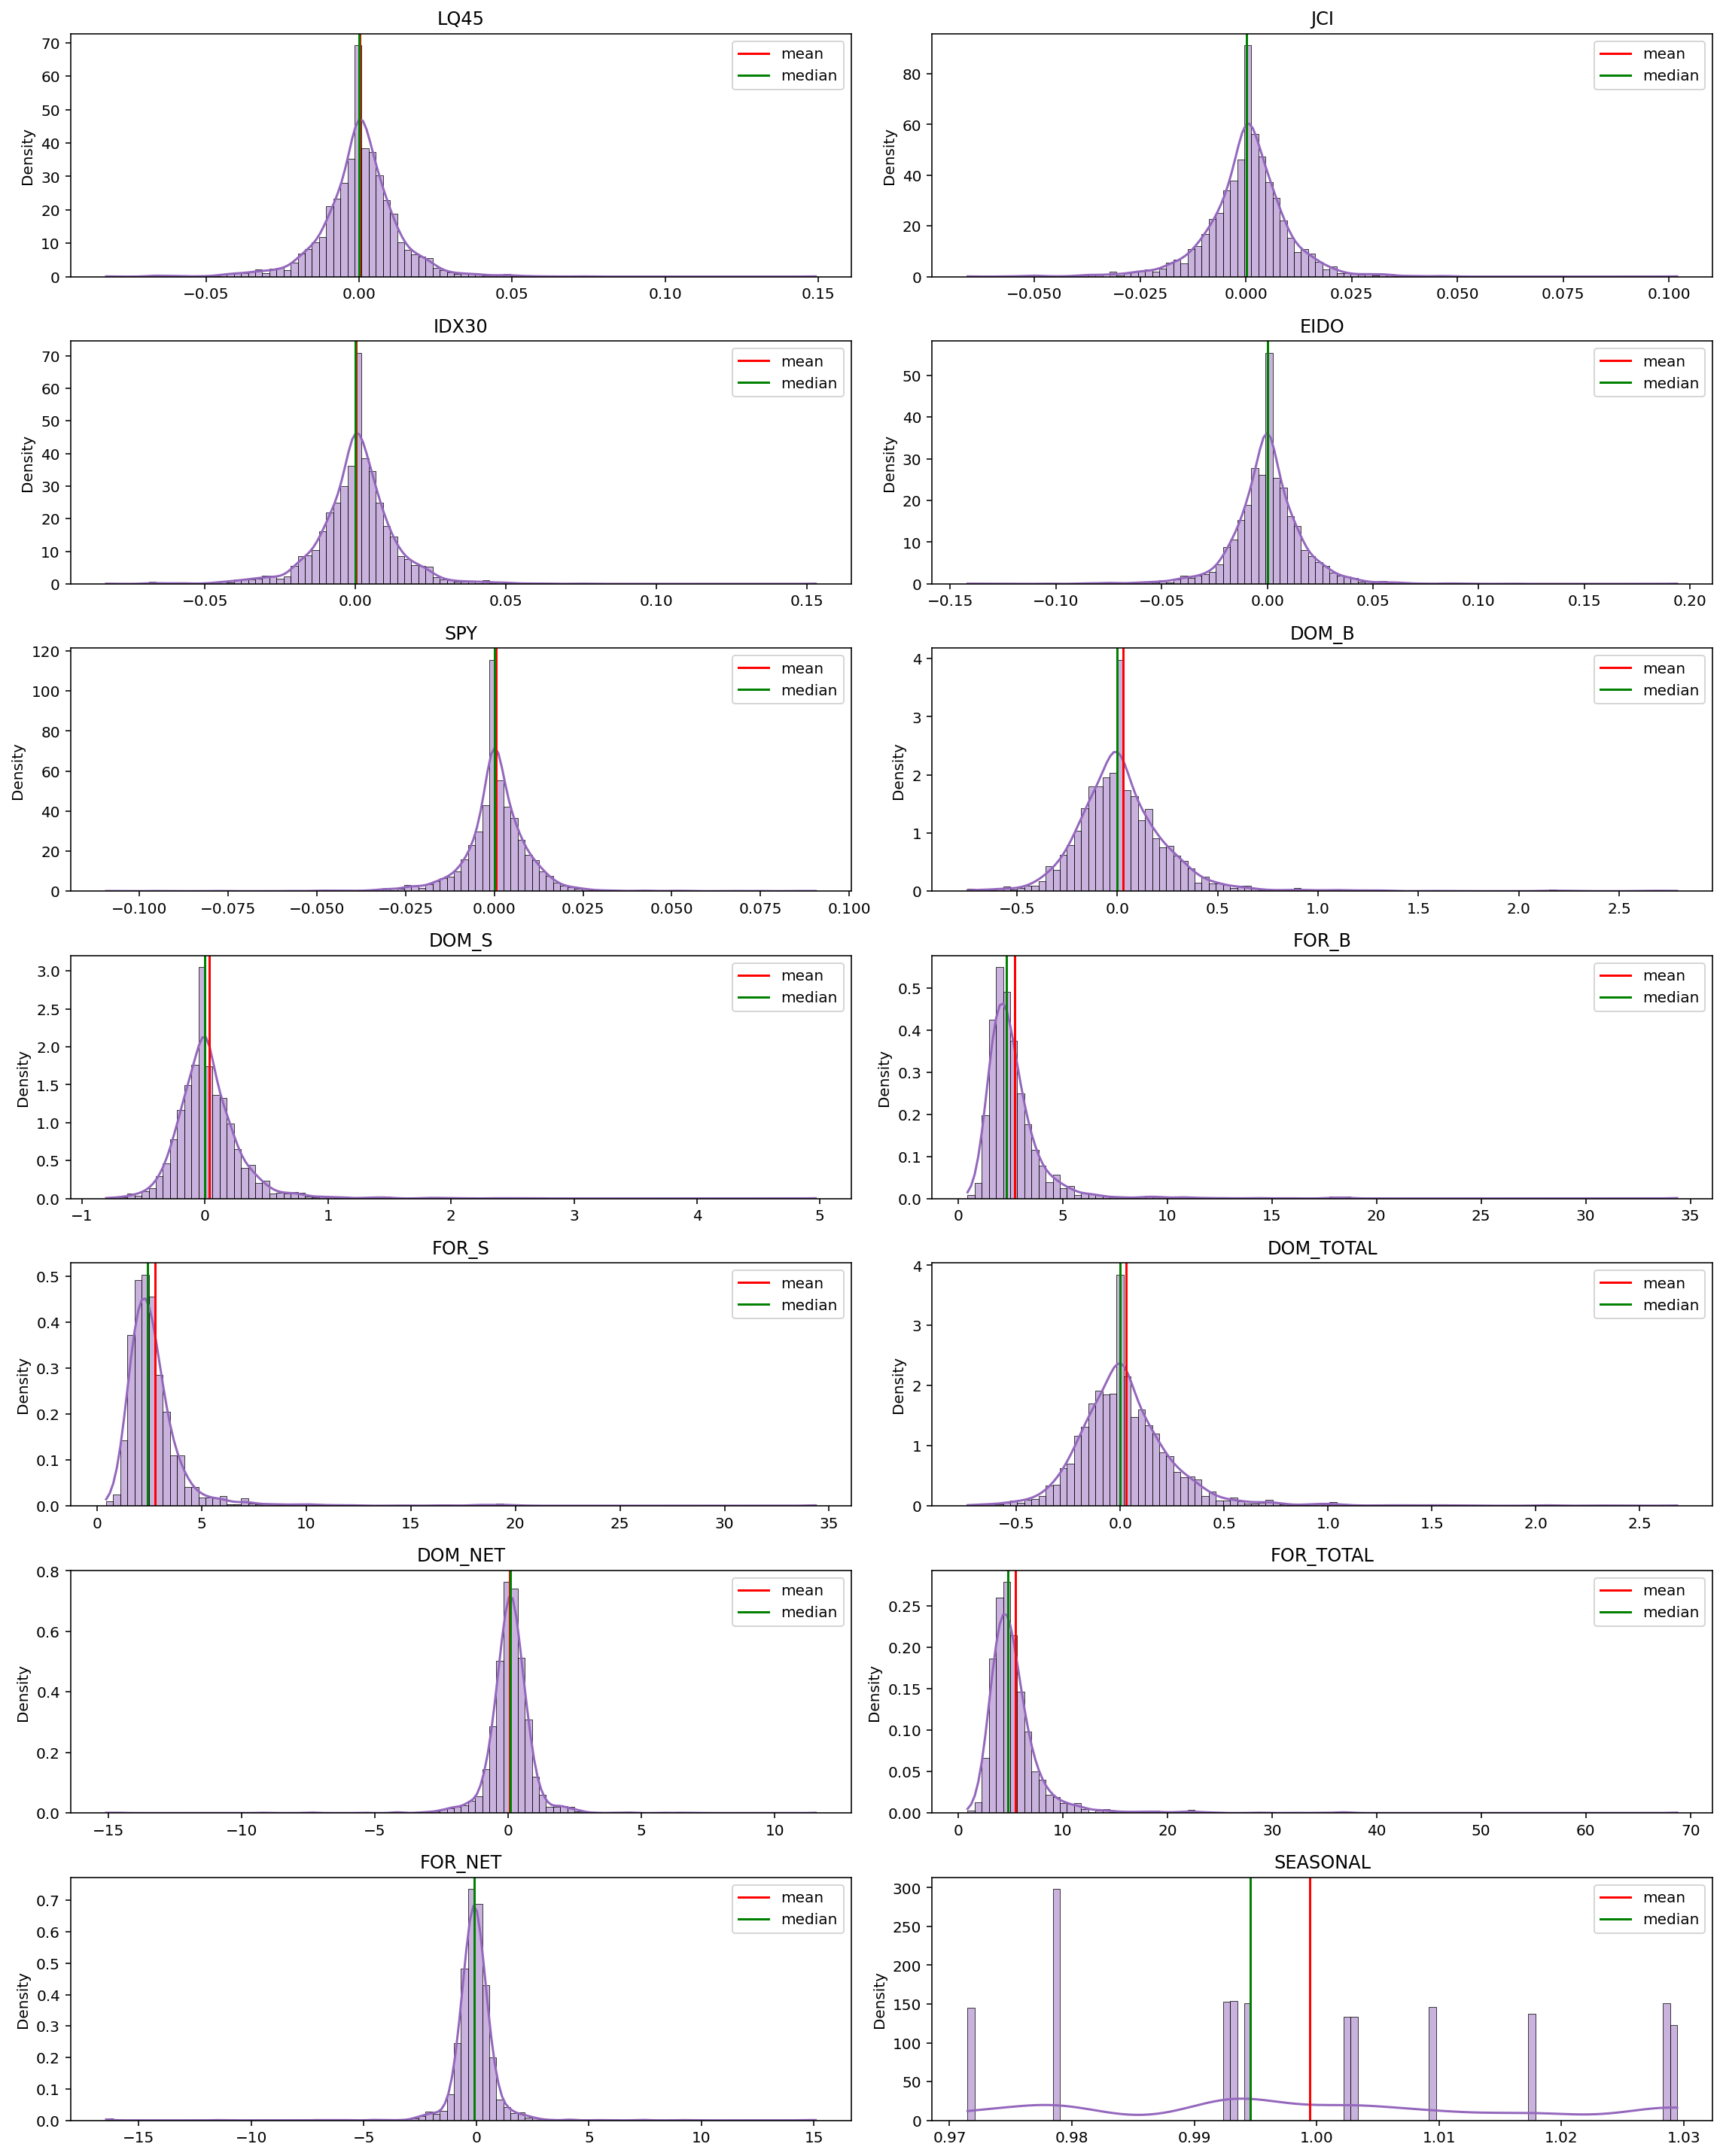

In [21]:
gf.plotting_hist_all(dataframe=df_train)

## Plotting: Boxplot

In [ ]:
gf.plotting_box_all(dataframe=df_train)

## Imputasi

In [ ]:
#df_value_for_outlier = DataPrep.get_value_for_outlier(train_dataframe=df_train, lo_perc=10.0, hi_perc=90.0)
#gf.create_pkl(obj=df_value_for_outlier, pkl=r'..\models\pkl\df_imputasi.pkl')
#df_value_for_outlier

In [ ]:
'''
DataPrep = data_preprocessing.DataPreprocessing()
df_value_for_outlier = DataPrep.get_value_for_outlier(train_dataframe=df_train, lo_perc=10.0, hi_perc=90.0)
df_train = DataPrep.outlier_treatment_batch(df_train, df_value_for_outlier=df_value_for_outlier)
df_valid = DataPrep.outlier_treatment_batch(df_valid, df_value_for_outlier=df_value_for_outlier)
df_test = DataPrep.outlier_treatment_batch(df_test, df_value_for_outlier=df_value_for_outlier)
gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train_04.pkl')
gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid_04.pkl')
gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test_04.pkl')
'''

# Standardizing

In [22]:
DataPrep = data_preprocessing.DataPreprocessing()
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_04.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_04.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_04.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

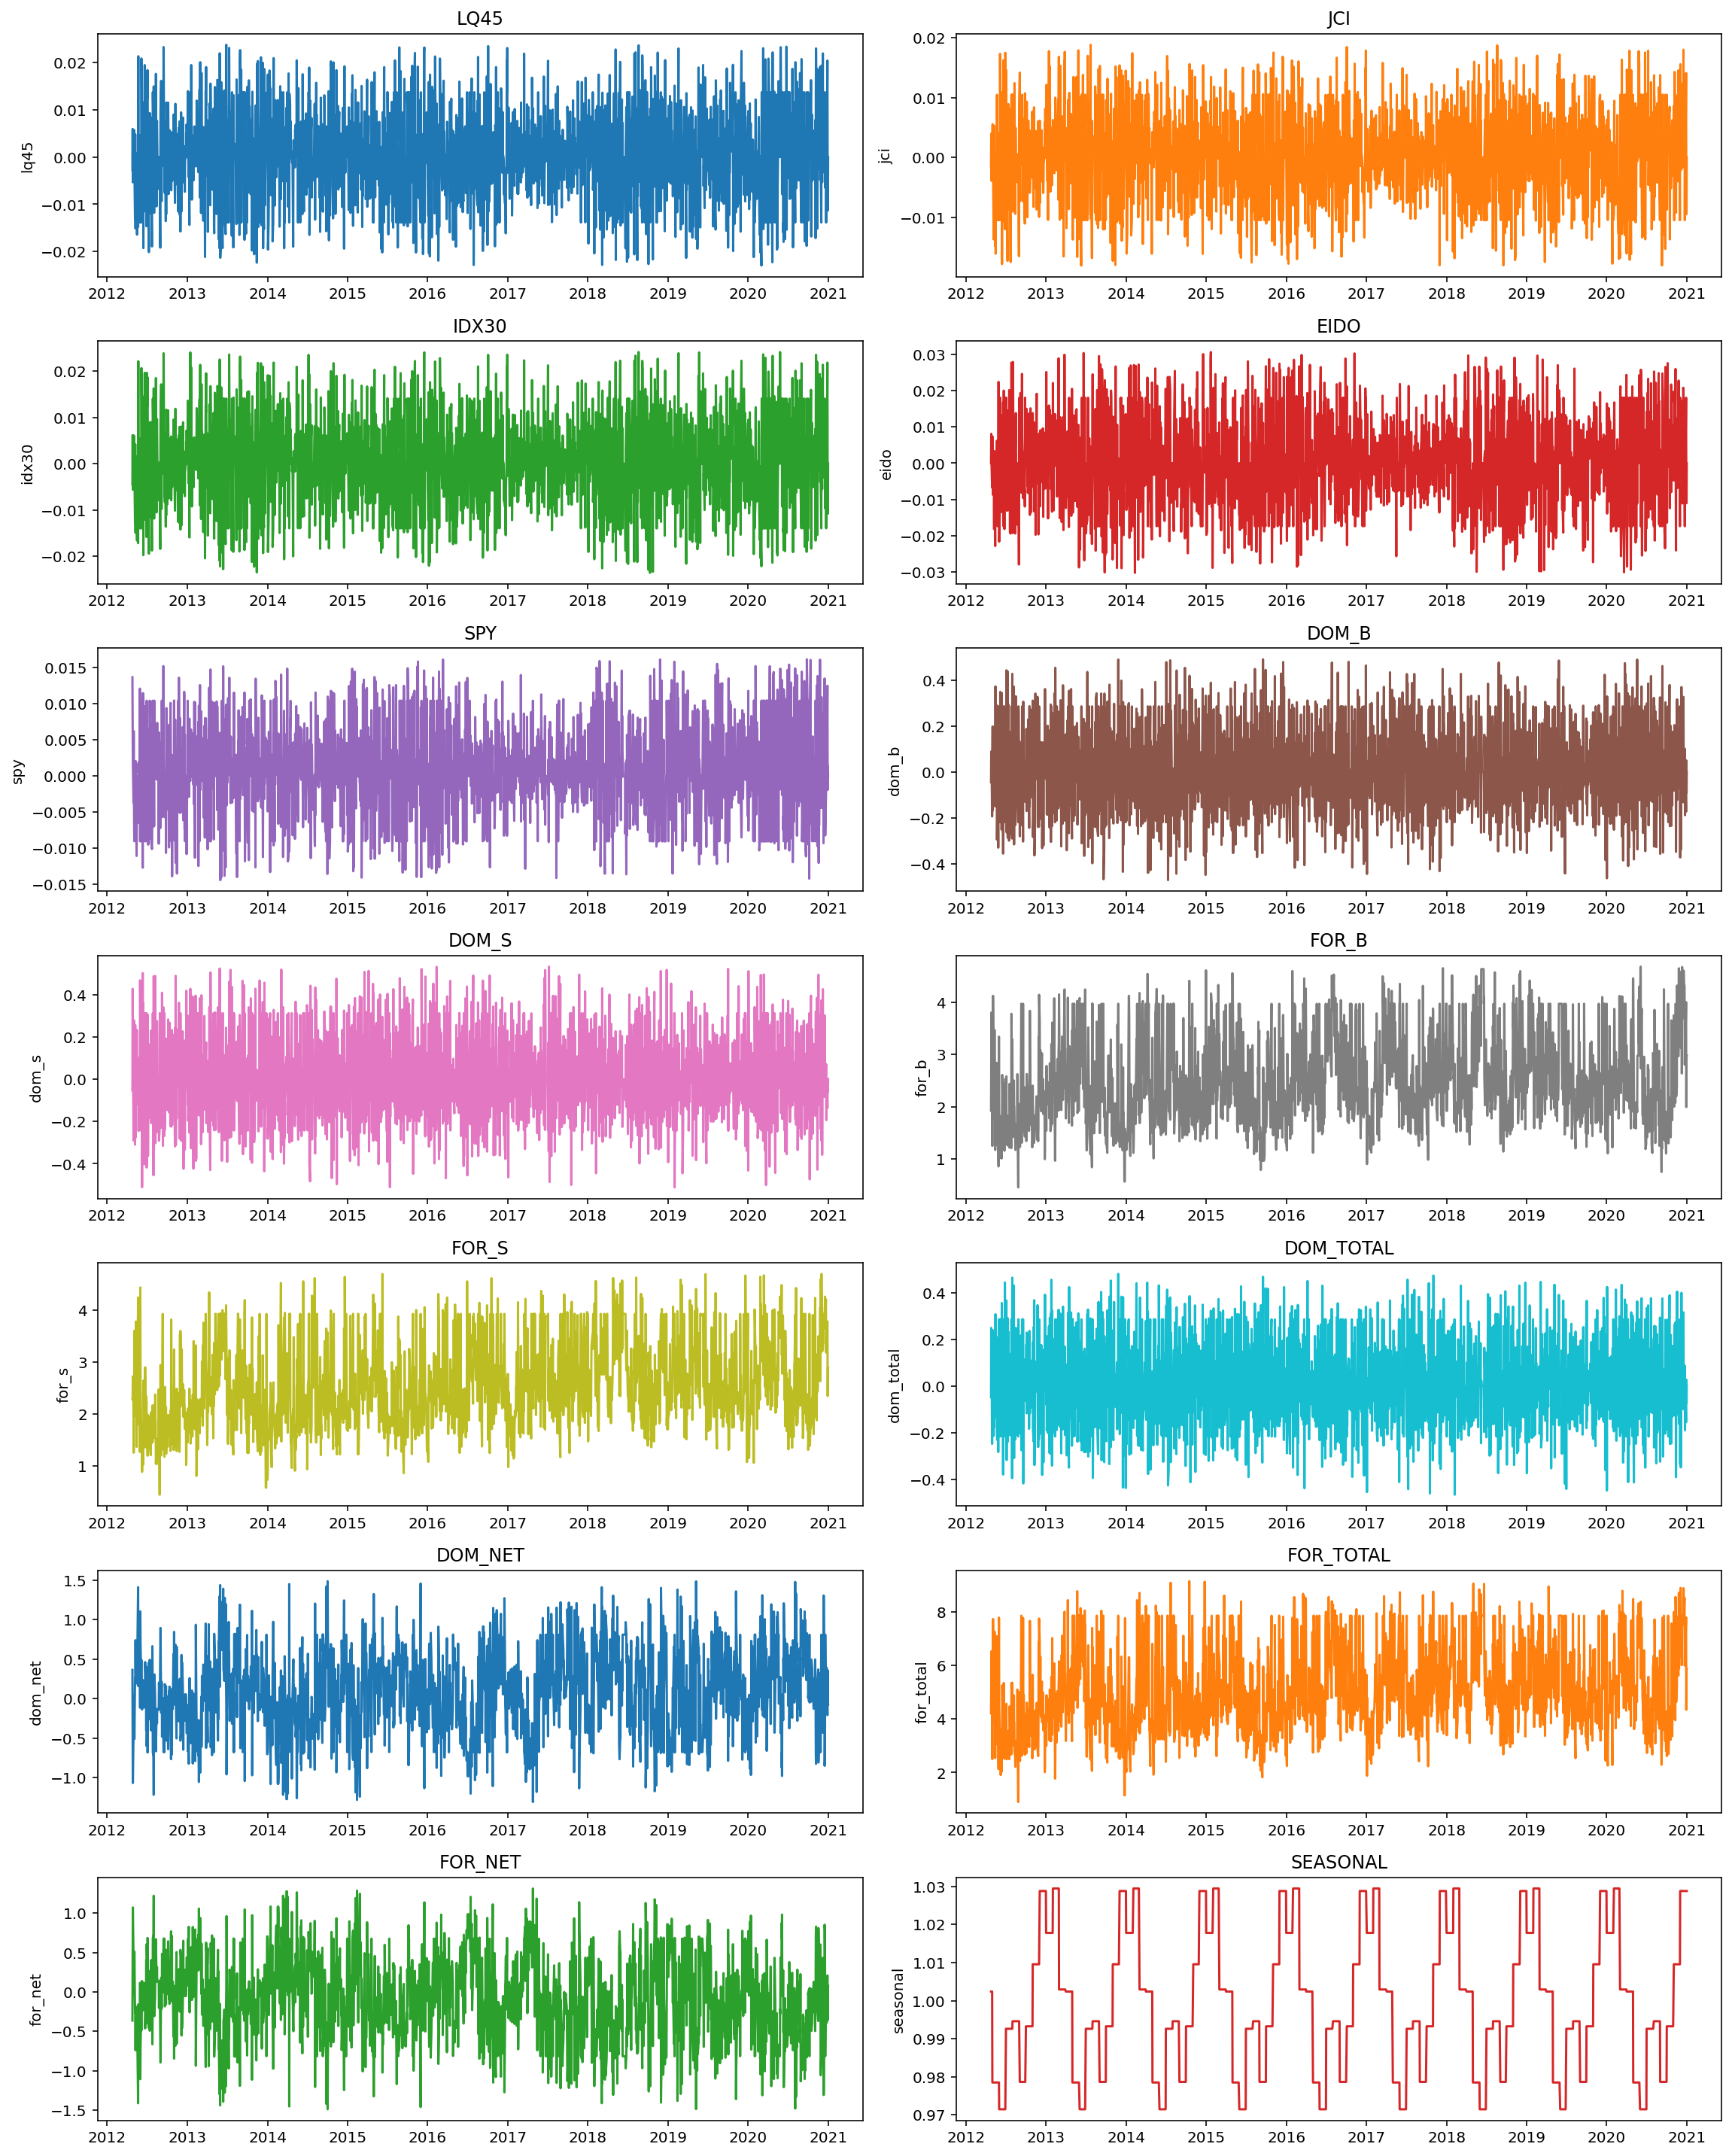

In [23]:
gf.plotting_line_all(dataframe=df_train)

In [ ]:
'''
DataPrep = data_preprocessing.DataPreprocessing()
scaler = DataPrep.std_scaler_fitting(train_dataframe=df_train)
df_train = DataPrep.std_scaler_transform(dataframe=df_train, scaler=scaler)
df_valid = DataPrep.std_scaler_transform(dataframe=df_valid, scaler=scaler)
df_test = DataPrep.std_scaler_transform(dataframe=df_test, scaler=scaler)
gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train_05.pkl')
gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid_05.pkl')
gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test_05.pkl')
'''

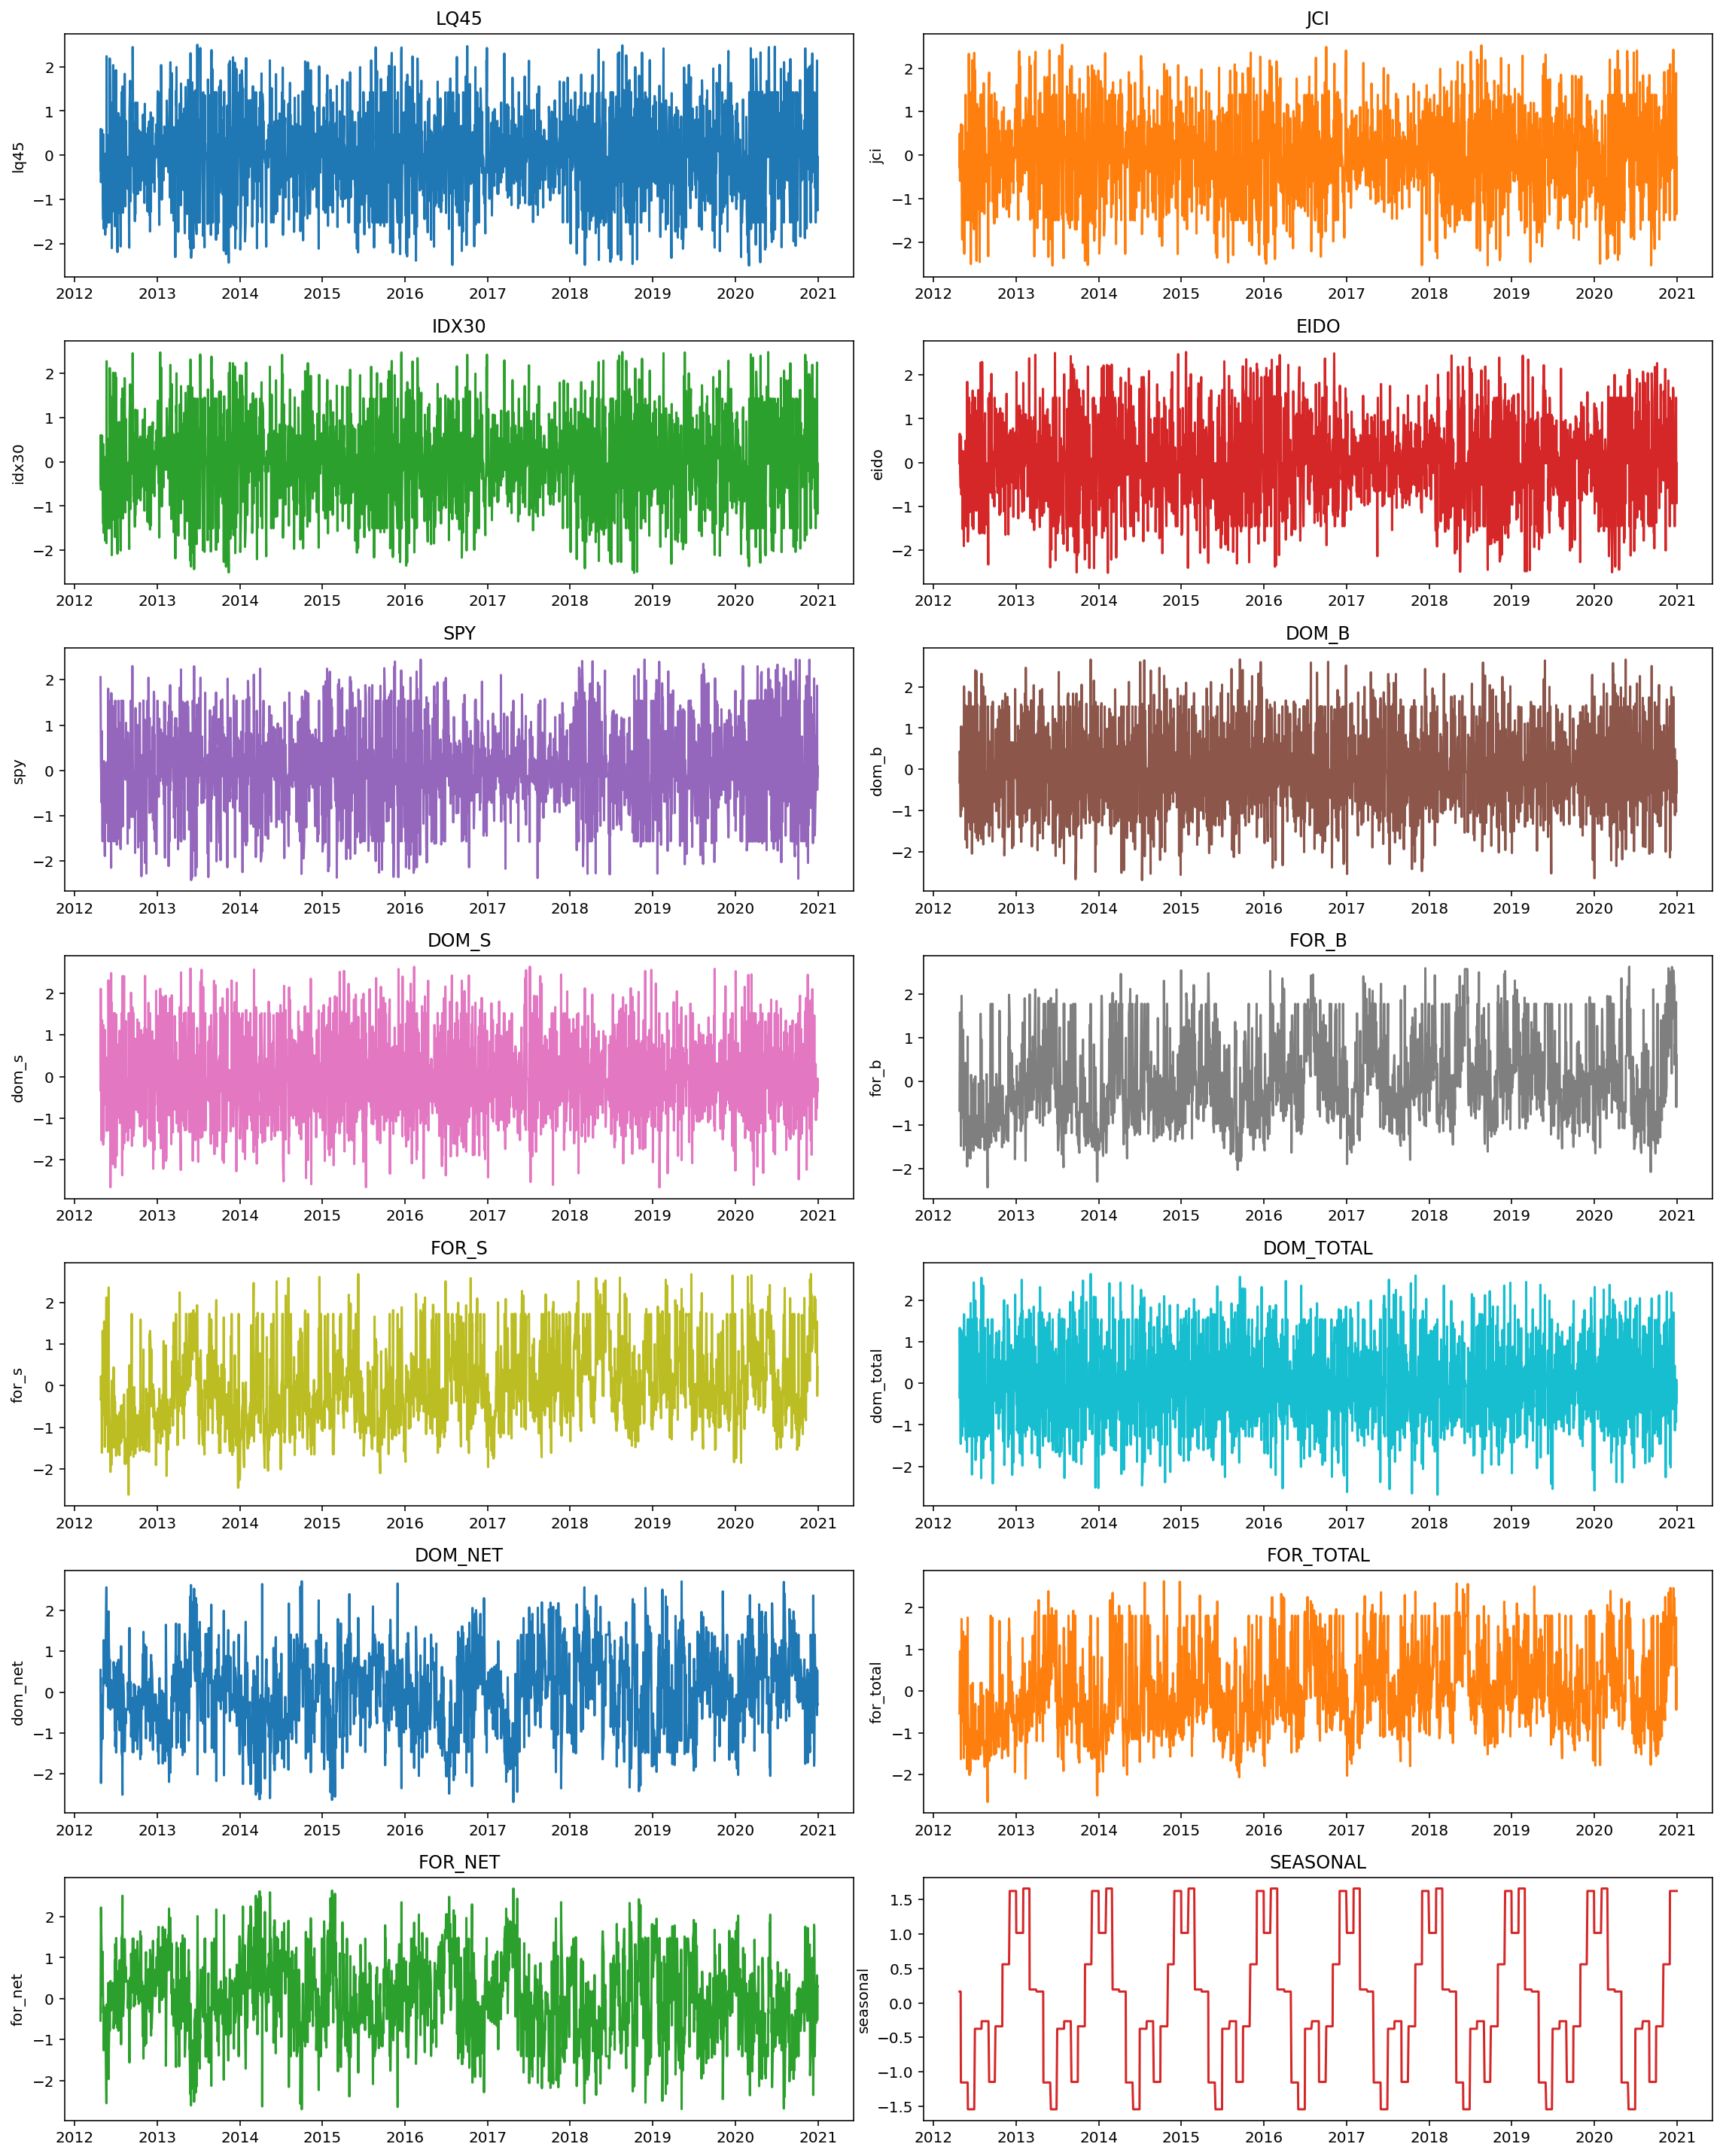

In [24]:
DataPrep = data_preprocessing.DataPreprocessing()
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_05.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_05.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_05.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

gf.plotting_line_all(dataframe=df_train)